In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import tensorflow as tf
from tqdm import tqdm, tqdm_notebook

## Neural Arithmetic Logic Unit (NALU)

NALU combines Simple NAC & Complex NAC to perform any type of arithmetic operation. NALU comprises the weighted combination of a simple NAC and a complex NAC mentioned above, controlled by a learned gate signal.

$$y = g*a+(1-g)*m$$
where,
$a = Wx$

$m = \exp [W(\log(|x|+\varepsilon))]$

$W= \tanh(\hat{W})\odot \sigma (\hat{M})$

$g = sigmoid(Gx)$, G is a trainable parameter

In the above equation, $a$ represents the Simple NAC layer & $m$ represents the Complex NAC layer. See, the other two notebooks in this directory for reference

## Complex Equations

Consider, the following equation -
$$y = 13a^{4}+5b^{3}-7c^{2}+2d$$

In [39]:
def equate(a, b, c, d):
    return float(13*(a**4)+5*(b**3)-7*(c**2)+2*d)

**Creating training data**

In [40]:
a = np.random.randint(low=10, high=10000, size=1000)
b = np.random.randint(low=10, high=10000, size=1000)
c = np.random.randint(low=10, high=10000, size=1000)
d = np.random.randint(low=10, high=10000, size=1000)

In [41]:
x_train = np.column_stack((a, b, c, d))
x_train = x_train.astype('float32')
y_train = [equate(x[0], x[1], x[2], x[3]) for x in x_train]

In [42]:
len(x_train), len(y_train)

(1000, 1000)

**Creating testing data**

In [86]:
a1 = np.random.randint(low=10, high=100, size=1000)
b1 = np.random.randint(low=10, high=100, size=1000)
c1 = np.random.randint(low=10, high=100, size=1000)
d1 = np.random.randint(low=10, high=100, size=1000)

In [87]:
x_test = np.column_stack((a1, b1, c1, d1))
x_test = x_test.astype('float32')
y_test = [equate(x[0], x[1], x[2], x[3]) for x in x_test]

In [88]:
len(x_test), len(y_test)

(1000, 1000)

**Loss Function**

In [89]:
def rmsle_loss(predicted_y, target_y, epsilon=0.000001):
    predicted_y = tf.squeeze(predicted_y)
    predicted_y = [x+epsilon for x in predicted_y]
    return tf.sqrt(tf.reduce_mean(tf.square(tf.math.log(predicted_y) - tf.math.log(target_y))))

In [90]:
def rmse_loss(predicted_y, target_y, epsilon=0.000001):
    predicted_y = tf.squeeze(predicted_y)
    return tf.sqrt(tf.reduce_mean(tf.square(predicted_y - target_y)))

**NALU**

In [91]:
n_epochs = 2000
alpha = 0.1
epsilon = 0.000001

In [106]:
W_simple_hat = tf.Variable(shape=[4, 1],
                        initial_value=tf.random.uniform(shape=[4, 1], minval=0, maxval=2),
                        trainable=True, name="W_hat")
M_simple_hat = tf.Variable(shape=[4, 1],
                        initial_value=tf.random.uniform(shape=[4, 1], minval=0, maxval=2),
                        trainable=True, name="M_hat")
W_complex_hat = tf.Variable(shape=[4, 1],
                        initial_value=tf.random.uniform(shape=[4, 1], minval=0, maxval=2),
                        trainable=True, name="W_hat")
M_complex_hat = tf.Variable(shape=[4, 1],
                        initial_value=tf.random.uniform(shape=[4, 1], minval=0, maxval=2),
                        trainable=True, name="M_hat")
# gate signal layer
G = tf.Variable(shape=[4, 1],
                    initial_value=tf.random.uniform(shape=[4, 1], minval=0, maxval=2),
                    trainable=True, name="Gate_weights")


In [107]:
# simple nac layer output
W_simple = tf.nn.tanh(W_simple_hat) * tf.nn.sigmoid(M_simple_hat) 
y_simple_pred = tf.matmul(x_train, W_simple)

# complex nac layer output
W_complex = tf.nn.tanh(W_complex_hat) * tf.nn.sigmoid(M_complex_hat) 
x_modified = tf.math.log(tf.abs(x_train) + epsilon)
y_complex_pred = tf.exp(tf.matmul(x_modified, W_complex))

# nalu output
g = tf.nn.sigmoid(tf.matmul(x_train, G))
y_out = g*y_simple_pred + (1-g)*y_complex_pred
print(f"Initial Loss: {rmsle_loss(y_out, y_train)}")

Initial Loss: 26.651687622070312


In [100]:
optimize = tf.keras.optimizers.Adam(learning_rate=alpha)

In [101]:
loss_history = []

In [108]:
def train(X, y, learning_rate=0.01):
    with tf.GradientTape() as t:
        # update weight matrix (W) -> restricted to [-1, 1]
        W_simple = tf.nn.tanh(W_simple_hat) * tf.nn.sigmoid(M_simple_hat) 
        # simple nac layer output
        y_simple_pred = tf.matmul(X, W_simple)

        # complex nac layer output
        W_complex = tf.nn.tanh(W_complex_hat) * tf.nn.sigmoid(M_complex_hat) 
        x_modified = tf.math.log(tf.abs(X) + epsilon)
        y_complex_pred = tf.exp(tf.matmul(x_modified, W_complex))

        # nalu output
        g = tf.nn.sigmoid(tf.matmul(X, G))
        y_out = g*y_simple_pred + (1-g)*y_complex_pred

        # calculate loss
        current_loss = rmsle_loss(y_out, y)
    dW_simple_hat, dM_simple_hat, dW_complex_hat, dM_complex_hat, dG = t.gradient(current_loss, (W_simple_hat, M_simple_hat, W_complex_hat, M_complex_hat, G))
    optimize.apply_gradients(zip([W_simple_hat, dM_simple_hat, dW_complex_hat, dM_complex_hat, dG], [W_simple_hat, M_simple_hat, W_complex_hat, M_complex_hat, G]))
    return current_loss

**Looping**

In [109]:
for epoch in range(n_epochs):
    current_loss = train(x_train, y_train)
    loss_history.append(current_loss)
    if epoch%500==0:
        print(f"Epoch: {epoch}\tLoss: {current_loss:.2f}")

Epoch: 0	Loss: 26.65
Epoch: 500	Loss: nan


KeyboardInterrupt: 

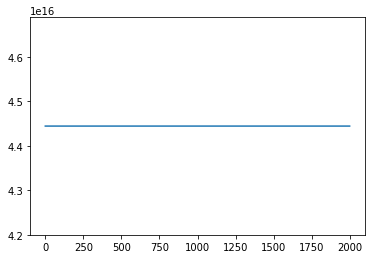

In [104]:
plt.plot(loss_history)

**Testing**

In [66]:
def get_pred(X):
    y_simple_pred = tf.matmul(X, W)
    x_modified = tf.math.log(tf.abs(X) + epsilon)
    y_complex_pred = tf.exp(tf.matmul(x_modified, W))
    g = tf.nn.sigmoid(tf.matmul(X, G))
    y_out = g*y_simple_pred + (1-g)*y_complex_pred
    return y_out

In [67]:
y_test_pred = get_pred(x_test)

In [70]:
13*(14**4)+5*(69**3)-7*(40**2)+2*41

2130835

In [68]:
for i in range(len(x_test))[:100]:
    print(f"Input: {x_test[i]}\tOutput: {y_test_pred[i].numpy()[0]:.2f}\tActual: {y_test[i]}")

Input: [14. 69. 40. 41.]	Output: 48.98	Actual: 2130835.0
Input: [57. 69. 23. 71.]	Output: 80.15	Actual: 138866997.0
Input: [74. 75. 60. 37.]	Output: 88.13	Actual: 391909737.0
Input: [13. 46. 40. 72.]	Output: 53.83	Actual: 846917.0
Input: [26. 89. 25. 78.]	Output: 70.25	Actual: 9461314.0
Input: [43. 97. 35. 41.]	Output: 71.17	Actual: 48999285.0
Input: [68. 31. 17. 55.]	Output: 70.07	Actual: 278104930.0
Input: [65. 91. 76. 10.]	Output: 81.12	Actual: 235785568.0
Input: [85. 55. 61. 23.]	Output: 84.82	Actual: 679413999.0
Input: [96. 69. 10. 99.]	Output: 109.28	Actual: 1105792571.0
Input: [47. 60. 97. 49.]	Output: 82.20	Actual: 64450088.0
Input: [46. 74. 87. 46.]	Output: 81.57	Actual: 60180157.0
Input: [95. 12. 87. 63.]	Output: 100.55	Actual: 1058813908.0
Input: [56. 68. 56. 36.]	Output: 74.82	Actual: 129398728.0
Input: [64. 61. 38. 90.]	Output: 92.57	Actual: 219228785.0
Input: [17. 22. 67. 97.]	Output: 65.66	Actual: 1107784.0
Input: [10. 94. 26. 56.]	Output: 54.74	Actual: 4278300.0
Input: 

In [69]:
for i in range(10):
    print(f"Input: {x_train[i]}\tOutput: {tf.matmul([x_train[i]], W)[0][0]:.2f}\tActual: {y_train[i]}")

Input: [0. 5.]	Output: 5.00	Actual: 5.0
Input: [ 5. 10.]	Output: 15.00	Actual: 15.0
Input: [10. 15.]	Output: 25.00	Actual: 25.0
Input: [15. 20.]	Output: 35.00	Actual: 35.0
Input: [20. 25.]	Output: 45.00	Actual: 45.0
Input: [25. 30.]	Output: 55.00	Actual: 55.0
Input: [30. 35.]	Output: 65.00	Actual: 65.0
Input: [35. 40.]	Output: 75.00	Actual: 75.0
Input: [40. 45.]	Output: 84.99	Actual: 85.0
Input: [45. 50.]	Output: 94.99	Actual: 95.0
